### Model of "A 32.2 TOPS/W SRAM Compute-in-Memory Macro Employing a Linear 8-bit C-2C Ladder for Charge Domain Computation in 22nm for Edge Inference", VLSI 2022

Paper by Hechen Wang, Renzhi Liu, Richard Dorrance, Deepak Dasalukunte, Xiaosen
Liu, Dan Lake, Brent Carlton, and May Wu



WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Some of the important variables for wang_vlsi_2022:

- *array_wordlines*: array_parallel_inputs * cim_unit_width_cells rows in the array
- *array_bitlines*: array_parallel_outputs * cim_unit_depth_cells columns in the array
- *array_parallel_inputs*: get_array_fanout_reuse_output(spec) input slice(s) consumed in each cycle.
- *array_parallel_weights*: get_array_fanout_total(spec) weights slice(s) used for computation in each cycle.
- *array_parallel_outputs*: get_array_fanout_reuse_input(spec) partial sums produced in each cycle.
- *tech_node*: 2.2e-08 m
- *adc_resolution*: 8 bit(s)
- *dac_resolution*: max(voltage_dac_resolution, temporal_dac_resolution) bit(s)
- *n_adc_per_bank*: 16 ADC(s)
- *supported_input_bits*: 8 bit(s)
- *supported_output_bits*: 8 bit(s)
- *supported_weight_bits*: 8 bit(s)
- *bits_per_cell*: 1 bit(s)
- *cim_unit_width_cells*: supported_weight_bits adjacent cell(s) in a wordline store bit(s) in one weight slice and process one input & output slice together
- *cim_unit_depth_cells*: 8 adjacent cell(s) in a bitline operate in separate cycles
- *cell_config*: /home/tanner/research/fusion/fastfusion/fastfusion/examples/arches/compute_in_memory/memory_cells/sram_wang_vlsi_2022.yaml 
- *cycle_period*: max(base_latency * no_faster_than_digital * voltage_latency_scale, limited_by_temporal_dac, 2e-9) second(s)

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


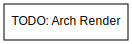

In [ ]:
from _scripts import (
    display_important_variables,
    get_spec,
    bar_comparison,
    bar_stacked,
    bar,
)
display_important_variables('wang_vlsi_2022')
get_spec('wang_vlsi_2022').arch

#### Description of The Macro

The macro uses a 512-row by 128-column SRAM array. Every eight adjacent columns
store 8b weight slices and together compute one 8b MAC operation. An 8b voltage
DAC provides 8b inputs in a single cycle. An analog-digital C-2C multiplier
computes a MAC operation between an 8b analog input and an 8b digital weight.
These multipliers allow the macro to compute 8b MACs in a single cycle and read
the results with one ADC convert. Furthermore, they allow the macro to avoid
connecting memory cells to analog circuits.

Every eight rows in the array share a C-2C multiplier. These rows are activated
in separate cycles, so it requires eight cycles to activate all rows in the
array.


In [ ]:
import fastfusion as ff
import matplotlib.pyplot as plt

#### Area Breakdown

This test replicates the results of Fig. 22(b) of the paper.

We show the area breakdown of the macro. The area is broken down into the
following components:

- ADC: Area consumed by the ADC
- DAC: Area consumed by the DAC
- MAC: Area consumed by the MAC, including the row drivers, select wordline
    drivers, CiM unit, and C-2C multiplier.
- Misc: Area consumed by the weight drivers and control circuitry.

Modeled miscellaneous area is lower than reference because we do not model
the control circuitry in the weight drivers.


In [ ]:
parsed = get_spec('wang_vlsi_2022').calculate_component_area_energy_latency_leak()

area = parsed.arch.per_component_total_area

TOTAL_AREA = 0.124e-6

expected_area = {
    "ADC": 0.13 * TOTAL_AREA,
    "DAC": 0.3 * TOTAL_AREA,
    "MAC": 0.46 * TOTAL_AREA,
    "Misc": 0.11 * TOTAL_AREA,
}
modeled = {}
modeled["ADC"] = area["ADC"] + area["ColumnDrivers"] + area["ColumnBandwidthLimiter"]
modeled["DAC"] = area["DAC"]
modeled["MAC"] = area["CimUnit"] + area["C2CMultiplier"] + area["C2CMultiplierPortB"] + area["RowDrivers"] + area["SelectWordlineDrivers"]
modeled["Misc"] = sum(area.values()) - sum(modeled.values()) + area["WeightDrivers"]
total_area = sum(modeled.values())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bar_comparison(
    {
        "Modeled": modeled,
        "Expected": expected_area,
    },
    "Component",
    "Area (mm^2)",
    "Area Breakdown: Modeled vs Expected",
    ax,
)

#### Energy Breakdown

This test replicates the results of Fig. 22(a) of the paper. We show the energy
breakdown of the macro. The energy is broken down into the following components:

- ADC: Energy consumed by the ADC
- DAC: Energy consumed by the DAC
- MAC: Energy consumed by the MAC, including the row drivers, select wordline drivers,
  CiM unit, and C-2C multiplier.
- Misc: The weight drivers are miscellaneous components in our model, but they consume
  no energy in this weight-stationary test. Misc also includes control circuitry in the
  reference.
  
Modeled miscellaneous energy is lower than reference because we do not model the control
circuitry.

In [ ]:
spec = get_spec('wang_vlsi_2022', add_dummy_main_memory=True)
spec.mapper.ffm.metrics = ff.mapper.FFM.Metrics.ENERGY
results = ff.mapper.FFM.map_workload_to_arch(spec)
energy = results.energy(per_component=True)

TOPS_PER_WATT = 16.37572276
PJ_PER_MVM = 2 / TOPS_PER_WATT * 16 * 64# * 8

expected_energy = {
    "ADC": PJ_PER_MVM * 0.34 * 1e-12,
    "DAC": PJ_PER_MVM * 0.22 * 1e-12,
    "MAC": PJ_PER_MVM * 0.4 * 1e-12,
    "Misc": PJ_PER_MVM * 0.04 * 1e-12,
}

modeled = {}
modeled["ADC"] = energy["ADC"] + energy["ColumnDrivers"] + energy["ColumnBandwidthLimiter"]
modeled["DAC"] = energy["DAC"]
modeled["MAC"] = energy["CimUnit"] + energy["C2CMultiplier"] + energy["C2CMultiplierPortB"] + energy["RowDrivers"] + energy["SelectWordlineDrivers"]
modeled["Misc"] = sum(energy.values()) - sum(modeled.values()) + energy["WeightDrivers"]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bar_comparison(
    {
        "Modeled": modeled,
        "Expected": expected_energy,
    },
    "Component",
    "Energy (J)",
    "Energy Breakdown: Modeled vs Expected",
    ax,
)

#### Energy Efficiency, Throughput, and Compute Density

This test replicates the results of Table III in the paper.

In this test, we show the energy efficiency, throughput, and compute density
of the macro at 0.7V and 1.1V supply voltages.

We see that increasing the supply voltage increases throughput at the cost of
lower energy efficiency.

In [ ]:
spec = get_spec('wang_vlsi_2022', add_dummy_main_memory=True)
spec.mapper.ffm.metrics = ff.mapper.Metrics.ENERGY

spec_parsed = spec.calculate_component_area_energy_latency_leak()
spec.variables.voltage = 0.7
results_a = ff.mapper.FFM.map_workload_to_arch(spec)
spec.variables.voltage = 1.1
results_b = ff.mapper.FFM.map_workload_to_arch(spec)

In [ ]:
per_compute_latency_a = results_a.per_compute().to_dict()["Total<SEP>latency"]
per_compute_latency_b = results_b.per_compute().to_dict()["Total<SEP>latency"]

tops_a = 2 / results_a.per_compute().to_dict()["Total<SEP>latency"] / 1e12
tops_b = 2 / results_b.per_compute().to_dict()["Total<SEP>latency"] / 1e12

tops_per_mm_a = tops_a / total_area / 1e6
tops_per_mm_b = tops_b / total_area / 1e6

tops_per_w_a = 2 / results_a.per_compute().energy() / 1e12
tops_per_w_b = 2 / results_b.per_compute().energy() / 1e12

# Structure the dictionaries flat from the start
modeled = {
    "0.7V tops_per_mm2": tops_per_mm_a,
    "0.7V tops_per_w": tops_per_w_a,
    "0.7V tops": tops_a,
    "1.1V tops_per_mm2": tops_per_mm_b,
    "1.1V tops_per_w": tops_per_w_b,
    "1.1V tops": tops_b,
}

expected = {
    "0.7V tops_per_mm2": 2.4,
    "0.7V tops_per_w": 32.2,
    "0.7V tops": 0.3,
    "1.1V tops_per_mm2": 4.0,
    "1.1V tops_per_w": 15.5,
    "1.1V tops": 0.5,
}

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set_yscale('log')
bar_comparison(
    {
        "Modeled": modeled,
        "Expected": expected,
    },
    "Metric",
    "Value",
    "Energy Efficiency, Throughput, and Compute Density",
    ax,
)

In [ ]:






# # def test_voltage_scaling():
# #     """
# #     ### Voltage Scaling

# #     This test replicates the results of Fig. 23 of the paper.

# #     We show the effects of voltage scaling on the energy efficiency and
# #     throughput of the macro, testing supply voltages of 0.7V, 0.8V, 0.9V, 1V,
# #     and 1.1V.

# #     We can see that increasing the supply voltage increases throughput and
# #     compute density at the cost of lower energy efficiency.

# #     Modeled and reference compute density varies because we did not model the
# #     area of some miscellaneous components, leading to the model having a smaller
# #     area and higher compute density. This could be corrected by adding
# #     additional components to the model. We also use a different scaling factor
# #     for voltage versus energy, leading to a different curve shape. This could be
# #     corrected by adjusting the VOLTAGE_ENERGY_SCALE formula and propagating the
# #     value to each subcomponent model.
# #     """
# #     results = utl.parallel_test(
# #         utl.delayed(utl.quick_run)(macro=MACRO_NAME, variables=dict(VOLTAGE=x))
# #         for x in [0.7, 0.8, 0.9, 1, 1.1]
# #     )

# #     for r, tops_mm, tops_w in zip(
# #         results,
# #         [2.377, 2.858, 3.200, 3.596, 3.941],
# #         [31.998, 22.590, 18.439, 16.376, 15.467],
# #     ):
# #         r.add_compare_ref("tops_per_mm2", tops_mm)
# #         r.add_compare_ref("tops_per_w", tops_w)
# #         r.add_compare_ref("tops", tops_mm * TOTAL_AREA / 1e6)
# #     return results


# # def test_tops():
# #     """
# #     ### Energy Efficiency, Throughput, and Compute Density

# #     This test replicates the results of Table III in the paper.

# #     In this test, we show the energy efficiency, throughput, and compute density
# #     of the macro at 0.7V and 1.1V supply voltages.

# #     We see that increasing the supply voltage increases throughput at the cost of
# #     lower energy efficiency.
# #     """
# #     results = utl.parallel_test(
# #         utl.delayed(utl.quick_run)(macro=MACRO_NAME, variables=dict(VOLTAGE=x))
# #         for x in [0.7, 1.1]
# #     )
# #     for r, tops_mm, tops_w, tops in zip(
# #         results,
# #         [2.4, 4.0],
# #         [32.2, 15.5],
# #         [0.3, 0.5],
# #     ):
# #         r.add_compare_ref("tops_per_mm2", tops_mm)
# #         r.add_compare_ref("tops_per_w", tops_w)
# #         r.add_compare_ref("tops", tops)
# #     return results


# # def test_full_system_dnn(dnn_name: str, batch_size: int = None):
# #     """
# #     ### Exploration of Full-System Energy Efficiency

# #     In this test, we look at the full-system energy breakdown when running DNNs
# #     on a CiM accelerator. We place the macro in a chip with local input/output
# #     buffers, routers for on-chip data movement, a global buffer, and DRAM. We
# #     show the area and energy spent on DRAM, the global buffer, and other
# #     components.

# #     We compare three scenarios:

# #     1. Inputs, outputs, and weights stored off-chip in DRAM and fetched for each
# #        layer
# #     2. Inputs and outputs fetched from DRAM, weights stationary (pre-loaded for
# #        each layer)
# #     3. Weights stationary, layers fused to keep inputs/outputs on-chip in the
# #        global

# #     We can see that weight-stationary processing significantly reduces overall
# #     energy due to fewer weight fetches from off-chip. Benefits are limited,
# #     however, because inputs and outputs still must be fetched from off-chip. To
# #     see further benefits, fusing layers is necessary to keep data on-chip
# #     between DNN layers. We note that weight-stationary CiM requires sufficient
# #     memory to keep all DNN weights on-chip. To store large DNNs, this may
# #     require a multi-chip pipeline or dense storage technologies.
# #     """

# #     dnn_dir = utl.path_from_model_dir(f"workloads/{dnn_name}")
# #     layer_paths = [
# #         os.path.join(dnn_dir, l) for l in os.listdir(dnn_dir) if l.endswith(".yaml")
# #     ]

# #     layer_paths = [l for l in layer_paths if "From einsum" not in open(l, "r").read()]

# #     if "gpt2_medium" in dnn_name:
# #         layer_paths = layer_paths[:-1]

# #     def callfunc(spec):
# #         spec.architecture.find("shared_router_group").spatial.meshX = 64
# #         spec.architecture.find("shared_router_group").attributes.has_power_gating = True
# #         spec.architecture.find("shared_router_group").constraints.spatial.no_reuse = []

# #         spec.architecture.find("tile_in_chip").spatial.meshX = 16
# #         spec.architecture.find("tile_in_chip").attributes.has_power_gating = True
# #         spec.architecture.find("tile_in_chip").constraints.spatial.no_reuse = []

# #         if batch_size is not None:
# #             spec.problem.instance["N"] = batch_size
# #         spec.architecture.find("output_buffer").constraints.temporal.iter_only = []

# #     results = utl.parallel_test(
# #         utl.delayed(utl.run_layer)(
# #             macro=MACRO_NAME,
# #             layer=l,
# #             variables=dict(EXPERIMENT_NAME=s),
# #             tile="input_output_bufs",
# #             chip="large_router_glb",
# #             system=system,
# #             callfunc=callfunc,
# #         )
# #         for l in layer_paths
# #         for s, system in (
# #             ('"All Tensors Off-Chip"', "fetch_all_lpddr4"),
# #             ('"Weight-Stationary"', "fetch_weights_lpddr4"),
# #             ('"Weight-Stationary + Fusion"', None),
# #         )
# #     )

# #     for r in results:
# #         r.per_component_energy.setdefault("main_memory", 0)

# #     results.combine_per_component_energy(
# #         [
# #             "c2c_multiplier_analog_port",
# #             "c2c_multiplier_digital_port",
# #             "cim_unit",
# #             "adc",
# #             "select_wordline_drivers",
# #             "row_drivers",
# #             "dac",
# #             "output_buffer",
# #             "input_buffer",
# #             "router",
# #             "weight_drivers",
# #             "column_drivers",
# #         ],
# #         "Macro & Other On-Chip Data Movement",
# #     )
# #     results.combine_per_component_energy(["glb"], "Global Buffer")
# #     results.combine_per_component_energy(["main_memory"], "Off-Chip DRAM")
# #     results.clear_zero_energies()

# #     return results


# if __name__ == "__main__":
#     test_energy_breakdown(),
#     test_area_breakdown(),
#     test_voltage_scaling(),
#     test_tops(),
#     test_full_system_dnn("resnet18")



# def test_tops():
#     """
#     """
#     results = utl.parallel_test(
#         utl.delayed(utl.quick_run)(macro=MACRO_NAME, variables=dict(VOLTAGE=x))
#         for x in [0.7, 1.1]
#     )
#     for r, tops_mm, tops_w, tops in zip(
#         results,
#         [2.4, 4.0],
#         [32.2, 15.5],
#         [0.3, 0.5],
#     ):
#         r.add_compare_ref("tops_per_mm2", tops_mm)
#         r.add_compare_ref("tops_per_w", tops_w)
#         r.add_compare_ref("tops", tops)
#     return results





# result = run_test("wang_vlsi_2022", "test_tops")

# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# bar_side_by_side(
#     {r.variables["VOLTAGE"]: r.tops for r in result},
#     xlabel="Voltage (V)",
#     ylabel="Throughput (TOPS)",
#     title="Voltage vs. Throughput",
#     ax=ax[0],
# )
# bar_side_by_side(
#     {r.variables["VOLTAGE"]: r.tops_per_w for r in result},
#     xlabel="Voltage (V)",
#     ylabel="Energy Efficiency (TOPS/W)",
#     title="Voltage vs. Energy Efficiency",
#     ax=ax[1],
# )
# bar_side_by_side(
#     {r.variables["VOLTAGE"]: r.tops_per_mm2 for r in result},
#     xlabel="Voltage (V)",
#     ylabel="Compute Density (TOPS/mm^2)",
#     title="Voltage vs. Compute Density",
#     ax=ax[2],
# )